In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import KernelPCA
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


PCA

In [2]:
combined_df_no_nans = pd.read_parquet("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_1/total_df_no_nans_and_labels.parquet")

In [3]:
#remove coordinates, labels, and desired features after correlation analysis
combined_df = combined_df_no_nans.drop(columns=['x', 'y','labels', 'chlor_a_min', 'chlor_a_max', 'log_ruggedness',
                                               'temperature_max','salinity_10th_percentile',  'salinity_90th_percentile',
                                               'current_speed_90th_percentile'])

In [4]:
print(combined_df.columns)

Index(['bathymetry', 'slope', 'fine_BPI_std', 'broad_BPI_std', 'aspect_cos',
       'aspect_sin', 'temperature_min', 'salinity_mean', 'current_speed_mean',
       'statistical_northness', 'statistical_eastness', 'current_aspect_angle',
       'chlor_a_mean'],
      dtype='object')


In [7]:
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(combined_df)

In [8]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

In [9]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 17.34%
PC1: 0.5604819725826785
PC2: 0.0734981215274002
PC3: 0.3796977335766594
PC4: 0.4439829162524304
PC5: -0.26072558711013427
PC6: 0.20317881486681705
PC7: -0.365868627648089
PC8: 0.02627179441673611


Principal Component 2: 16.15%
PC1: 0.1089219008839143
PC2: -0.07604018506329202
PC3: 0.06178272155011965
PC4: 0.08269934704489894
PC5: 0.538893468419308
PC6: 0.46889991765531913
PC7: -0.04353406140863426
PC8: 0.005907106675871822


Principal Component 3: 15.79%
PC1: -0.27356508065637364
PC2: 0.05584004181423899
PC3: 0.5396130726659184
PC4: 0.5670116627222402
PC5: 0.2178701930478223
PC6: -0.29925501798460685
PC7: 0.31712584976930047
PC8: -0.022550086073272975


Principal Component 4: 11.80%
PC1: -0.10063757376212752
PC2: 0.8150785020834006
PC3: -0.007761315950774102
PC4: -0.07312817357757372
PC5: 0.2690811101936047
PC6: -0.05515725071853244
PC7: 0.07972350626649496
PC8: -0.013335519979492956


Principal Component 5: 10.83%
PC1: -0.5106288015495302
PC2: 0.26728003

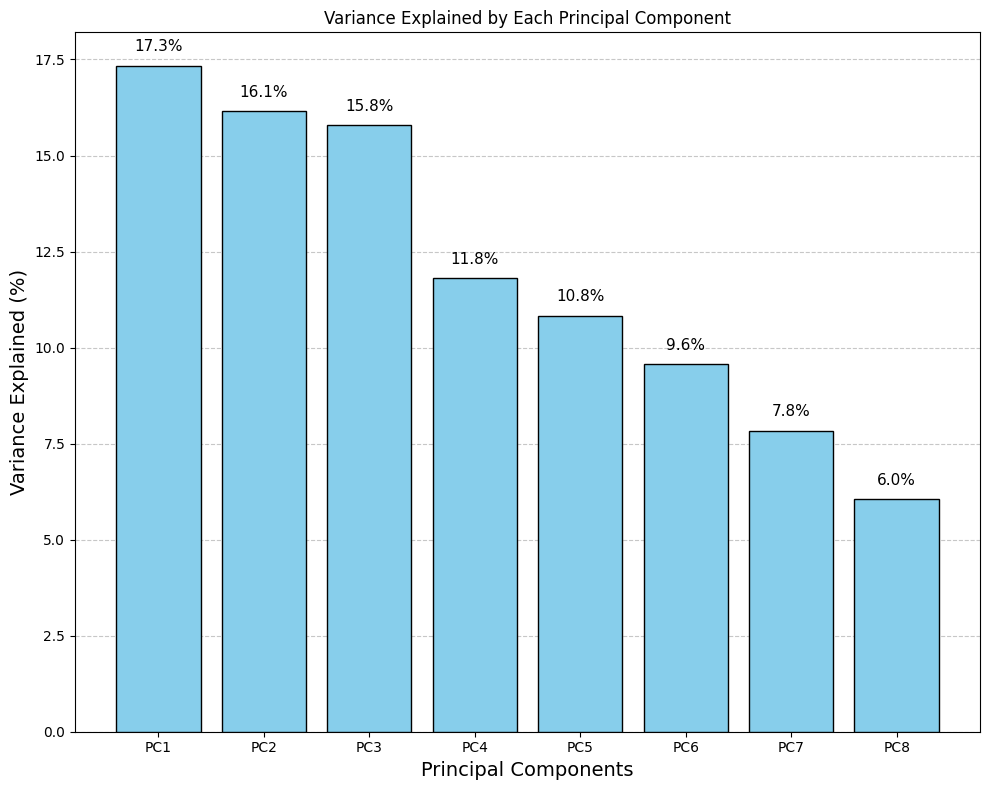

In [10]:
pca_variance = [17.34, 16.15, 15.79, 11.80, 10.83, 9.56, 7.83, 6.05]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()


In [11]:
loadings = pca.components_.T 

loading_df = pd.DataFrame(loadings, index=combined_df.columns, 
                          columns=[f'PC{i+1}' for i in range(loadings.shape[1])])


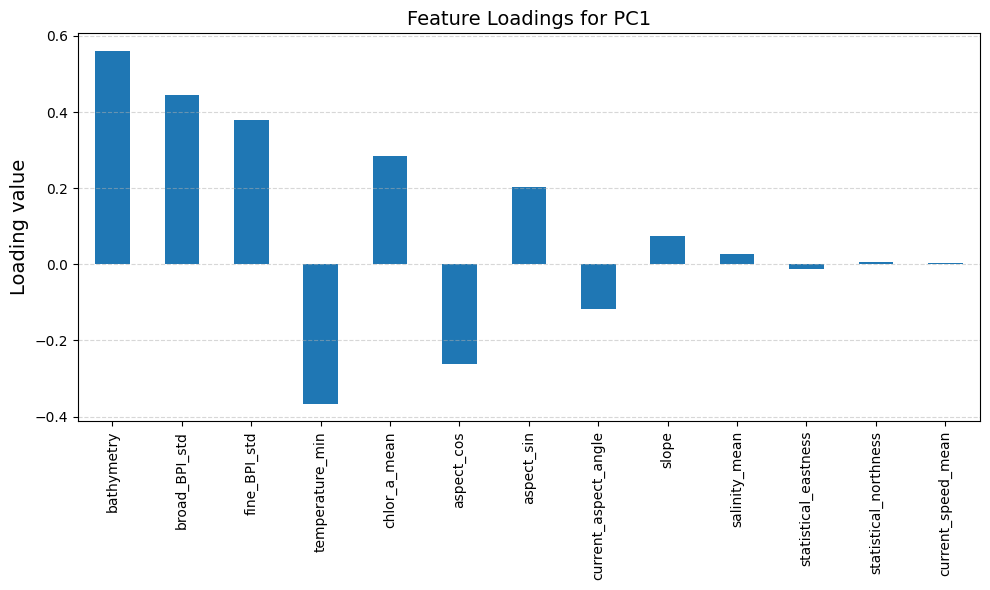

In [12]:
pc1_loadings = loading_df['PC1'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc1_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC1", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


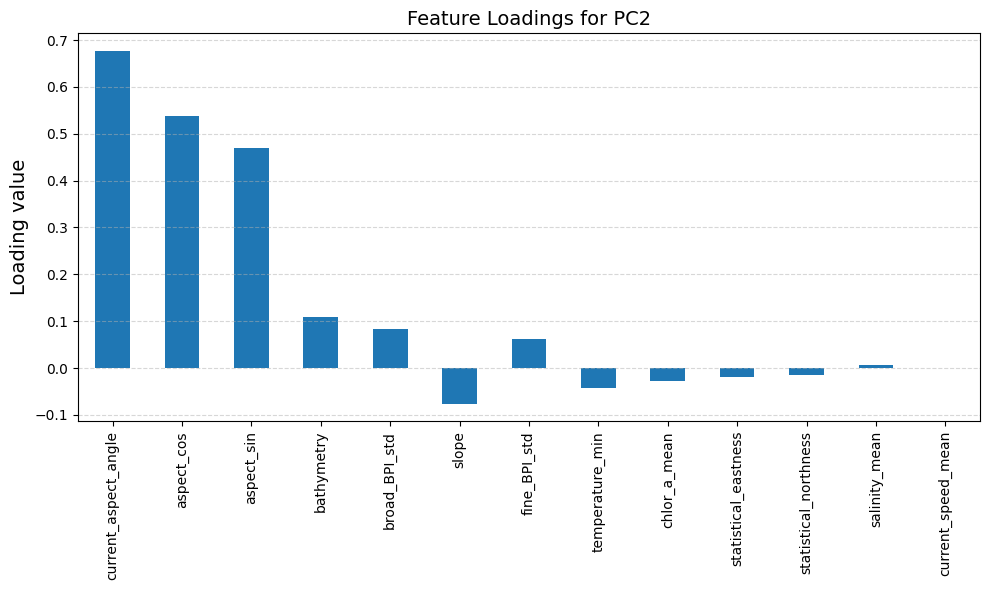

In [13]:
pc2_loadings = loading_df['PC2'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc2_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC2", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


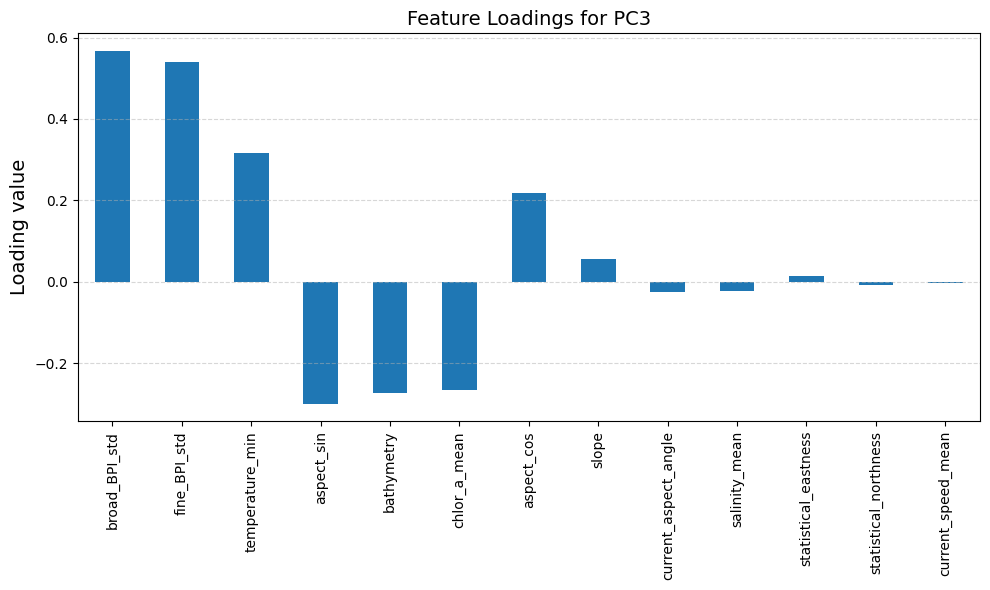

In [14]:
pc3_loadings = loading_df['PC3'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc3_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC3", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


PLS

In [5]:
X = combined_df
y = combined_df_no_nans[['labels']]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, Y_train)

PLSRegression()

In [8]:
X_scores, Y_scores = pls.transform(X_train), pls.predict(X_train)

In [9]:
Y_train_pred = pls.predict(X_train)
Y_test_pred = pls.predict(X_test)

#Explained variance
print("X Loadings:", pls.x_loadings_)
print("Y Loadings:", pls.y_loadings_)

X Loadings: [[ 0.40118802 -0.35162557]
 [ 0.35801876  0.41986555]
 [ 0.2494632  -0.09142441]
 [ 0.22614127 -0.26481345]
 [-0.29405677 -0.06605819]
 [-0.01621784 -0.33540809]
 [-0.47972013  0.14946141]
 [ 0.28355502 -0.34049123]
 [ 0.2488093  -0.34953767]
 [-0.10085628 -0.07095274]
 [ 0.20453346  0.58855874]
 [-0.06082109  0.18289586]
 [ 0.39262847 -0.20396737]]
Y Loadings: [[0.0042291  0.00143514]]


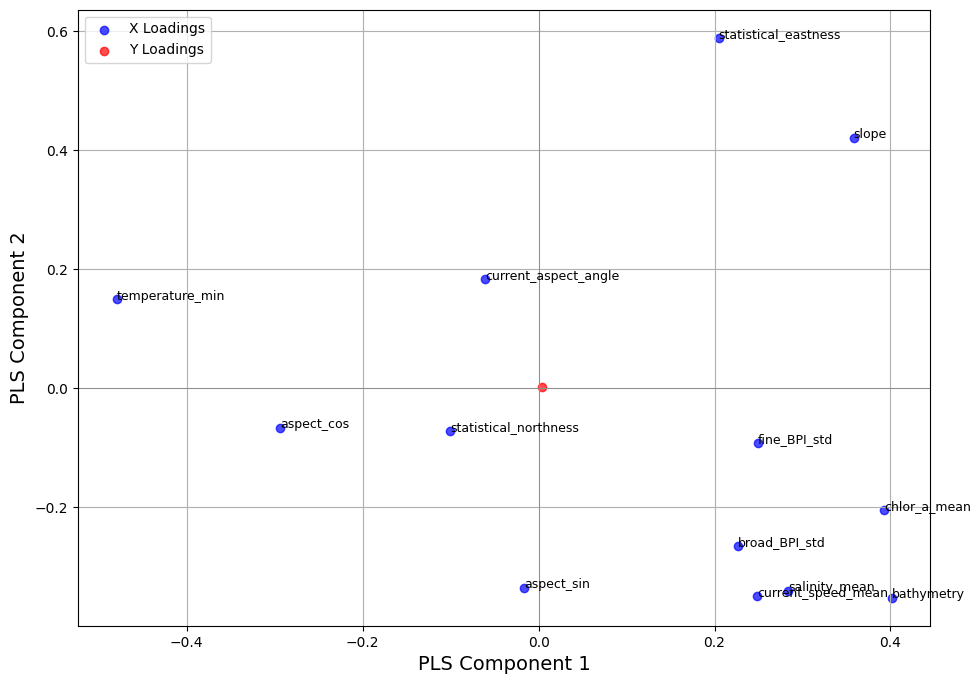

In [11]:
loadings_X = pls.x_loadings_
loadings_Y = pls.y_loadings_

plt.figure(figsize=(11, 8))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings', color='blue', alpha=0.7)
plt.scatter(loadings_Y[:, 0], loadings_Y[:, 1], label='Y Loadings', color='red', alpha=0.7)

for i, feature in enumerate(X_train.columns):
    plt.text(loadings_X[i, 0], loadings_X[i, 1], feature, fontsize=9)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PLS Component 1", fontsize=14)
plt.ylabel("PLS Component 2", fontsize=14)
#plt.title("PLS Loading Plot", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

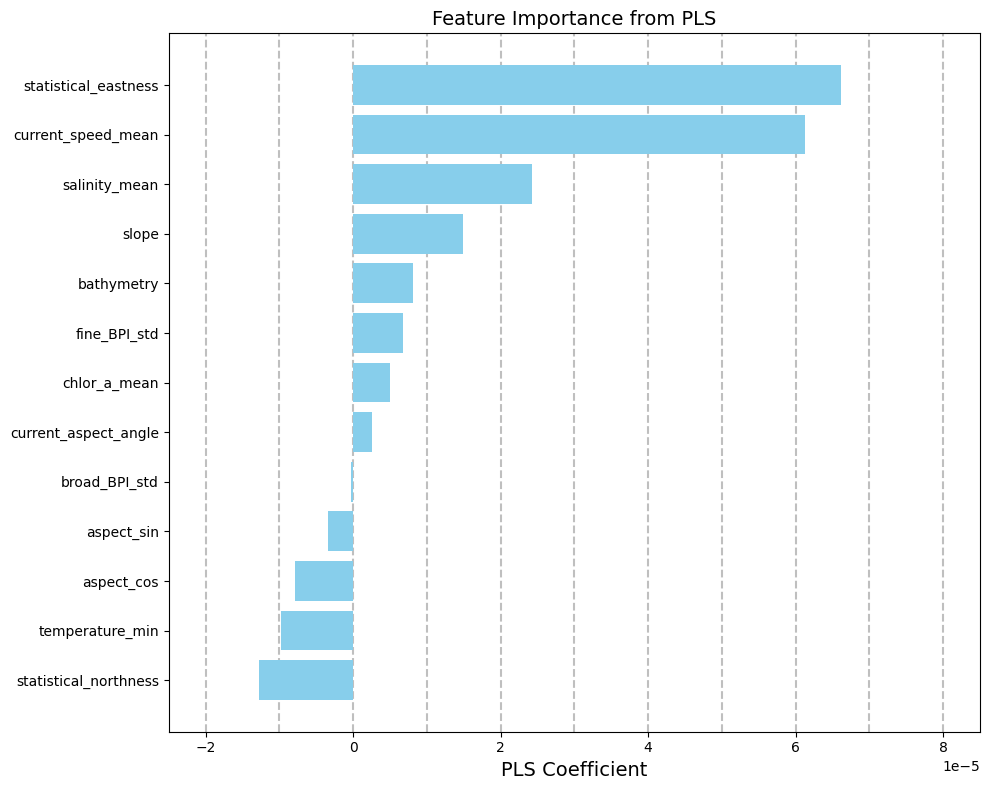

In [12]:
import matplotlib.pyplot as plt
import numpy as np

features = X.columns
coefficients = pls.coef_.ravel()

sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color="skyblue")
xticks = plt.xticks()[0]
for x in xticks:
    plt.axvline(x=x, linestyle='--', color='gray', alpha=0.5, zorder=0)
plt.title("Feature Importance from PLS", fontsize=14)
plt.xlabel("PLS Coefficient", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout() 
plt.show()

Kernel PCA 

In [ ]:
feature_map = Nystroem(kernel='rbf', gamma=0.1, n_components=50)
X_mapped = feature_map.fit_transform(combined_df)

pca = PCA(n_components=10)
#pca = PCA(n_components=0.95)
X_kpca_approx = pca.fit_transform(X_mapped)

In [13]:
pca_df = pd.DataFrame(data=X_kpca_approx, columns=[f'PC{i+1}' for i in range(X_kpca_approx.shape[1])])

In [14]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 17.71%
PC1: -0.08991180958349226
PC2: -0.044759406646146416
PC3: -0.0002872419272758967
PC4: -0.12540256468724031
PC5: 0.1626454879944741
PC6: 0.01579721282096847
PC7: -0.1799042701892041
PC8: -0.13909947398420977
PC9: -0.11657076125846015
PC10: 0.04489184716370534


Principal Component 2: 16.96%
PC1: 0.17716796938398344
PC2: 0.16934655844825686
PC3: -0.0014596775842747127
PC4: -0.1345953093738967
PC5: -0.20454640818806627
PC6: 0.1097254448600806
PC7: 0.15848831292611937
PC8: -0.023895410881808386
PC9: 0.22047220011634086
PC10: -0.21457926522809154


Principal Component 3: 12.14%
PC1: 0.17841486776155113
PC2: 0.14074286443084866
PC3: -0.00851087619053468
PC4: -0.0935357821046039
PC5: 0.06392197336237329
PC6: -0.009902742669984026
PC7: 0.21091248936371956
PC8: -0.19781010722160133
PC9: 0.1663322216520096
PC10: 0.28158010930688326


Principal Component 4: 9.85%
PC1: -0.016397157385975317
PC2: -0.027864828204456703
PC3: -0.009104099136105367
PC4: 0.12930580323781687

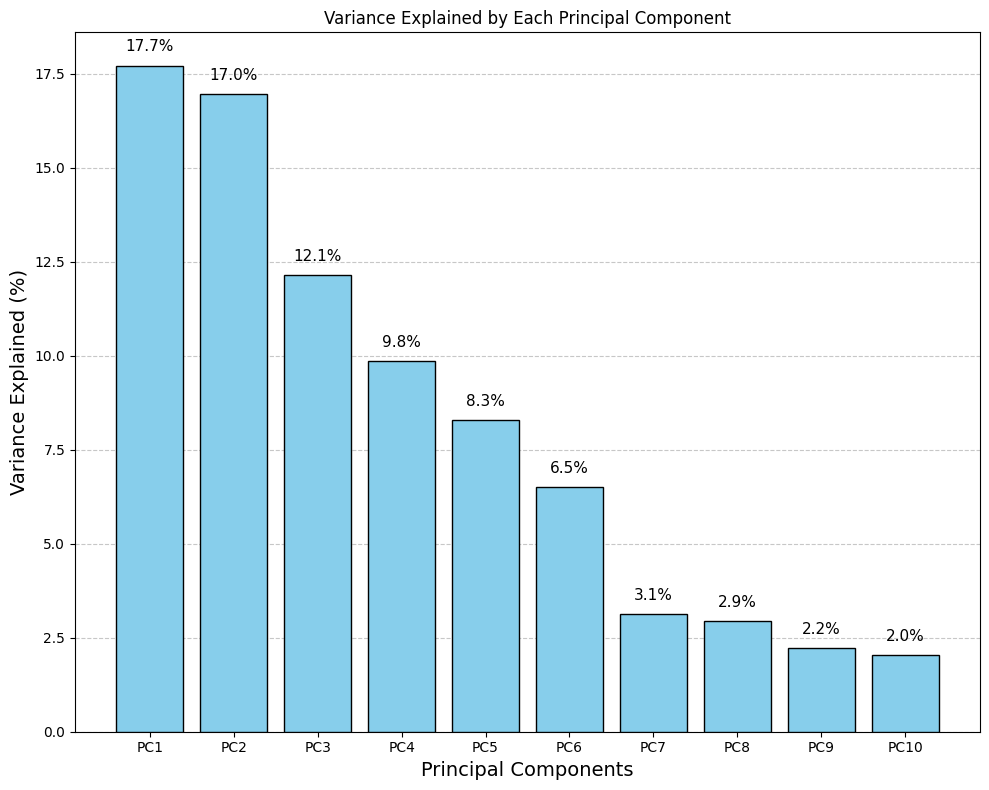

In [15]:
pca_variance = [17.71, 16.96, 12.14, 9.85, 8.28, 6.50, 3.12, 2.94, 2.23, 2.04]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()